# POKEMON SCRAPING

In [ ]:
In this project I have scraped the data from the POKEMON database

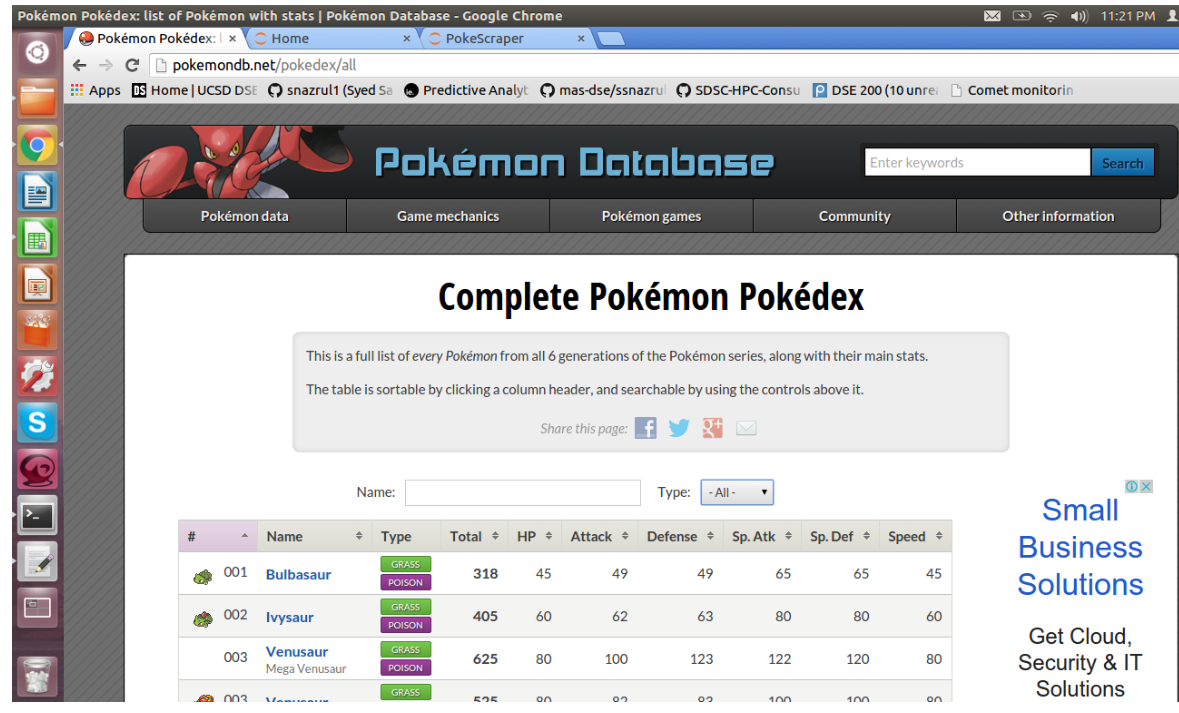

Starting off, we will try scraping the online Pokemon Database (http://pokemondb.net/pokedex/all).

Before moving further, we need to check how the web page is structured. To do this, we inspect by righ-clicking on any element on the table and clicking 'Inspect element'.

Based on the HTML codes, the data are stored in after <tr..

In [ ]:
import requests, six
import lxml.html as lh
from itertools import cycle, islice
from matplotlib import colors
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

First, we will get the url using Python's requests library.

After that, we store the contents of the page under doc.

Using doc, we can collect all data that are under <tr... as tr_elements.

Just to make sure we collected information only from the table, we will check the size of the first 12 rows

In [3]:

url='http://pokemondb.net/pokedex/all'


In [4]:
#Create a handle, page, to handle the contents of the website
page = requests.get(url)

#Store the contents of the website under doc
doc = lh.fromstring(page.content)

#Parse data that are stored between <tr>..</tr> of the site's HTML code
tr_elements = doc.xpath('//tr')

#Check the length of the first 12 rows
[len(T) for T in tr_elements[:12]]

[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]

 All the rows are of the same length of 10.

This means all the data collected on tr_elements are from the table.

Next, let's parse the first row as our header.

In [8]:

tr_elements = doc.xpath('//tr')

#Create empty list
col=[]
i=0

#For each row, store each first element (header) and an empty list
for t in tr_elements[0]:
    i+=1
    name=t.text_content()
    print (i,name)
    col.append((name,[]))

1 #
2 Name
3 Type
4 Total
5 HP
6 Attack
7 Defense
8 Sp. Atk
9 Sp. Def
10 Speed



Each header is appended to a tuple along with an empty list.

Let's populate these empty lists with the corresponding data!

In [9]:
#Since out first row is the header, data is stored on the second row onwards
for j in range(1,len(tr_elements)):
    #T is our j'th row
    T=tr_elements[j]
    
    #If row is not of size 10, the //tr data is not from our table 
    if len(T)!=10:
        break
    
    #i is the index of our column
    i=0
    
    #Iterate through each element of the row
    for t in T.iterchildren():
        data=t.text_content() 
        #Check if row is empty
        if i>0:
        #Convert any numerical value to integers
            try:
                data=int(data)
            except:
                pass
        #Append the data to the empty list of the i'th column
        col[i][1].append(data)
        #Increment i for the next column
        i+=1

Just to be sure, let's check the length of each column. Ideally, they should all be the same.

In [10]:
[len(C) for (title,C) in col]

[918, 918, 918, 918, 918, 918, 918, 918, 918, 918]

In [11]:
Dict={title:column for (title,column) in col}
import pandas as pd
df=pd.DataFrame(Dict)

In [12]:
df.head()

,#,Attack,Defense,HP,Name,Sp. Atk,Sp. Def,Speed,Total,Type
0,001,49,49,45,Bulbasaur,65,65,45,318,GrassPoison
1,002,62,63,60,Ivysaur,80,80,60,405,GrassPoison
2,003,82,83,80,Venusaur,100,100,80,525,GrassPoison
3,003,100,123,80,VenusaurMega Venusaur,122,120,80,625,GrassPoison
4,004,52,43,39,Charmander,60,50,65,309,Fire


 CLEANING DATA

In [13]:
def str_bracket(word):
    '''Add brackets around second term'''
    list = [x for x in word]
    for char_ind in range(1, len(list)):
        if list[char_ind].isupper():
            list[char_ind] = ' ' + list[char_ind]
    fin_list = ''.join(list).split(' ')
    length = len(fin_list)
    if length>1:
        fin_list.insert(1,'(')
        fin_list.append(')')
    return ' '.join(fin_list)

    
def str_break(word):
    '''Break strings at upper case'''
    list = [x for x in word]
    for char_ind in range(1, len(list)):
        if list[char_ind].isupper():
            list[char_ind] = ' ' + list[char_ind]
    fin_list = ''.join(list).split(' ')
    return fin_list

In [15]:
word = 'ILovePokemon'


In [16]:
str_bracket(word)

'I ( Love Pokemon )'

In [17]:
str_break(word)

['I', 'Love', 'Pokemon']

In [18]:
df['Name']=df['Name'].apply(str_bracket)
df['Type']=df['Type'].apply(str_break)
df.head()

,#,Attack,Defense,HP,Name,Sp. Atk,Sp. Def,Speed,Total,Type
0,001,49,49,45,Bulbasaur,65,65,45,318,"[Grass, Poison]"
1,002,62,63,60,Ivysaur,80,80,60,405,"[Grass, Poison]"
2,003,82,83,80,Venusaur,100,100,80,525,"[Grass, Poison]"
3,003,100,123,80,Venusaur ( Mega Venusaur ),122,120,80,625,"[Grass, Poison]"
4,004,52,43,39,Charmander,60,50,65,309,[Fire]


STORING DATA

In [19]:
df.to_json('PokemonData.json')

In [20]:
df = pd.read_json('PokemonData.json')
df=df.set_index(['#'])
df.head()

,Attack,Defense,HP,Name,Sp. Atk,Sp. Def,Speed,Total,Type
#,,,,,,,,,
1,49,49,45,Bulbasaur,65,65,45,318,"[Grass, Poison]"
2,62,63,60,Ivysaur,80,80,60,405,"[Grass, Poison]"
8,63,80,59,Wartortle,65,80,58,405,[Water]
80,75,110,95,Slowbro,100,80,30,490,"[Water, Psychic]"
80,75,180,95,Slowbro ( Mega Slowbro ),130,80,30,590,"[Water, Psychic]"


STATISTICAL ANALYSYS

In [21]:
def max_stats(df, col_list):
    '''Get Pokemon highest value of the column in the Data Frame'''
    message = ''
    for col in col_list:
        stat = df[col].max()
        name = df[df[col]==df[col].max()]['Name'].values[0]
        message += name+' has the greatest '+col+' of '+str(stat)+'.\n'
    return message

def min_stats(df, col_list):
    '''Get Pokemon lowest value of the column in the Data Frame'''
    message = ''
    for col in col_list:
        stat = df[col].min()
        name = df[df[col]==df[col].min()]['Name'].values[0]
        message += name+' has the worst '+col+' of '+str(stat)+'.\n'
    return message

In [25]:
stats=['Attack', 'Defense','HP', 'Sp. Atk','Sp. Def','Speed','Total']





In [26]:
max_stats(df, stats)

'Mewtwo ( Mega  Mewtwo  X ) has the greatest Attack of 190.\nSteelix ( Mega  Steelix ) has the greatest Defense of 230.\nBlissey has the greatest HP of 255.\nMewtwo ( Mega  Mewtwo  Y ) has the greatest Sp. Atk of 194.\nShuckle has the greatest Sp. Def of 230.\nDeoxys ( Speed  Forme ) has the greatest Speed of 180.\nMewtwo ( Mega  Mewtwo  X ) has the greatest Total of 780.\n'

In [27]:
min_stats(df, stats)

'Chansey has the worst Attack of 5.\nChansey has the worst Defense of 5.\nShedinja has the worst HP of 1.\nShuckle has the worst Sp. Atk of 10.\nCaterpie has the worst Sp. Def of 20.\nShuckle has the worst Speed of 5.\nWishiwashi ( Solo  Form ) has the worst Total of 175.\n'

C:\Users\CHINMAY\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: 'pandas.tools.plotting.scatter_matrix' is deprecated, import 'pandas.plotting.scatter_matrix' instead.
  This is separate from the ipykernel package so we can avoid doing imports until


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000022B80489F98>,
      dtype=object)

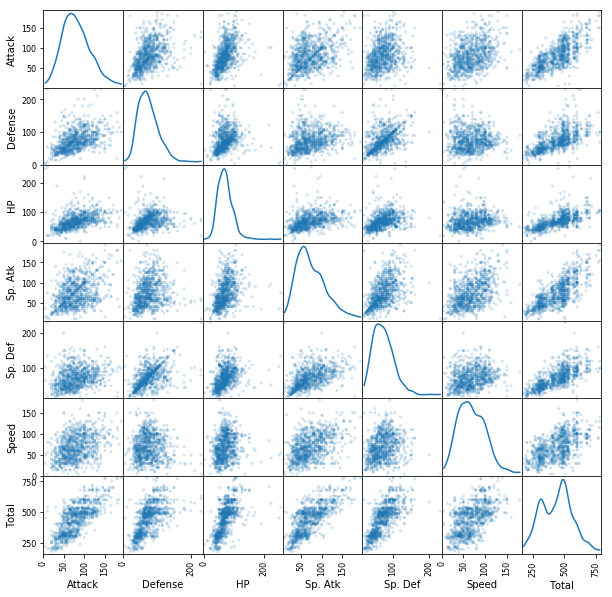

In [28]:
from pandas.tools.plotting import scatter_matrix

scatter_matrix(df[stats], alpha=0.2, figsize=(10, 10), diagonal='kde')

C:\Users\CHINMAY\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: 'pandas.tools.plotting.scatter_matrix' is deprecated, import 'pandas.plotting.scatter_matrix' instead.
  This is separate from the ipykernel package so we can avoid doing imports until


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000022B840DC7B8>,
      dtype=object)

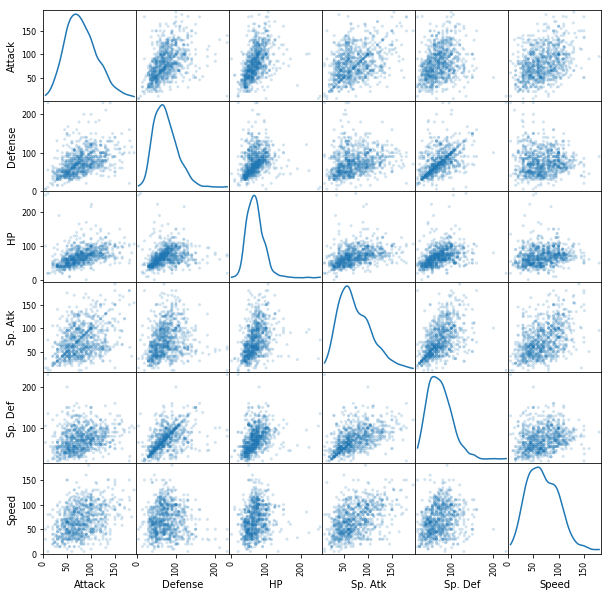

In [29]:

#'Total' is the last element of stats and hence taken out from the scatter matrix#'Total' 
scatter_matrix(df[stats[:-1]], alpha=0.2, figsize=(10, 10), diagonal='kde')

In [30]:
#Creating new Data Frame where the Type values are separated from the list
newDict={}
stats_col=["#","Name","Total","HP","Attack","Defense","Sp. Atk","Sp. Def","Speed"]

#Collecting the list of Type for each Pokemon
Dict['Type']=df['Type'].values

#Creating an empty list for each key (column)
for col in stats_col:
    newDict[col]=[]
    newDict['Type']=[]

#Populating each the dictionary value (empty list) with data 
for row in range(len(Dict['#'])):
    for t in Dict['Type'][row]:
        for col in stats_col:
            #Append all columns except Type to the new dictionary
            newDict[col].append(Dict[col][row])
        #Appending the Type separately for each Pokemon  in the new dictionary
        newDict['Type'].append(t)
        
#Convert dictionary to a Data Frame
new_df = pd.DataFrame(newDict)

In [32]:
new_df.head()

,#,Attack,Defense,HP,Name,Sp. Atk,Sp. Def,Speed,Total,Type
0,001,49,49,45,Bulbasaur,65,65,45,318,Grass
1,001,49,49,45,Bulbasaur,65,65,45,318,Poison
2,002,62,63,60,Ivysaur,80,80,60,405,Grass
3,002,62,63,60,Ivysaur,80,80,60,405,Poison
4,003,82,83,80,Venusaur,100,100,80,525,Water


In [33]:
types=new_df['Type'].unique()

In [34]:
types

array(['Grass', 'Poison', 'Water', 'Psychic', 'Electric', 'Steel',
       'Normal', 'Flying', 'Ice', 'Dark', 'Ghost', 'Rock', 'Ground',
       'Dragon', 'Bug', 'Fire', 'Fighting', 'Fairy'], dtype=object)

In [35]:

#Colours to cycle through when plotting the hbar graph#Colours 
my_colors = list(six.iteritems(colors.cnames))
my_colors = list(islice(cycle(my_colors), None, len(new_df)))

def barh_stats():
    '''Plot hbar of mean and std. of each attribute of Pokemon Type'''
    i=0
    plt.figure(figsize=(15,5))
    plt.suptitle('Statistics', fontsize=15)
    
    
    #Cycle through each pokemon Type
    for t in types:
        
        #Iterate i value to change colour to my_colors[i]
        i+=1   
        
        #Plotting Mean
        plt.subplot(121)
        plt.title('Mean')
        new_df[new_df['Type']==t].mean().plot(kind='barh', color=my_colors[i])
        
        #Plotting Standard Deviation
        plt.subplot(122)
        plt.title('Standard Deviation')
        new_df[new_df['Type']==t].std().plot(kind='barh', color=my_colors[i])
    
    #Add list of Pokemon Type to legend
    plt.legend(types,bbox_to_anchor=(1.3, 1.1))

C:\Users\CHINMAY\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


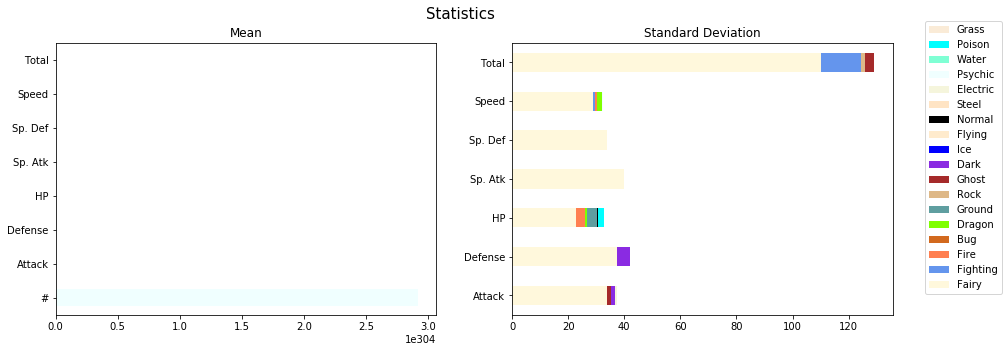

In [36]:
barh_stats()

In [44]:
import pandas as pd
import sys, urllib
import requests
import PyQt5 as pyqt

from PyQt5 import QtGui, QtCore

class PokeDex(pyqt.QtWidgets.QWidget):
    
    def __init__(self):
        super(PokeDex, self).__init__()
        
        self.initUI()
        
    def initUI(self):
        '''Initial UI'''
        
        #Grid Layout
        self.grid = QtWidgets.QGridLayout()
        self.setLayout(self.grid)
        
        #Parse JSON for DataFrame
        self.df = pd.read_json('PokemonData.json')
        self.df = self.df.set_index(['#'])
        
        #Drop Down
        self.dropdown = QtWidgets.QComboBox(self)
        self.names = self.df['Name'].values
        self.dropdown.addItems(self.names)
        self.grid.addWidget(self.dropdown, 0,0,1,1)
        
         #Search Button
        self.btn = QtWidgets.QPushButton('Search', self)
        self.btn.clicked.connect(self.runSearch())      
        self.grid.addWidget(self.btn, 0,1,1,1)
        
        #Image
        self.img = QtGui.QLabel(self)
        self.grid.addWidget(self.img, 1,1,1,1)
        
        #Data
        self.label = QtGui.QLabel(self)
        self.label.setAlignment(QtCore.Qt.AlignCenter)
        self.label.setText('\nName:\n\nType:\n\nHP:\n\nAttack\n\nSp. Attack\n\n Defense:\n\nSp. Defense:\n\nSpeed:\n\nTotal:')
        self.label.setAlignment(QtCore.Qt.AlignLeft)
        self.grid.addWidget(self.label, 1,0,1,1)
        
        #Customize Widgets
        self.resize(500, 250)
        self.center()
        self.setWindowTitle('PokeDex')    
        self.show()
        
        def runSearch(self):
            '''Event for run button'''
        
        #Parse value
        index = self.dropdown.currentIndex()
        val= self.names[index]
        cond = self.df['Name']== val
        
        #Image
        base = 'http://img.pokemondb.net/artwork/'
        img_url = base + val.lower() + '.jpg'
        data = urllib.urlopen(img_url).read()
        image = QtGui.QImage()
        image.loadFromData(data)
        self.img.setPixmap(QtGui.QPixmap(image))
        
        #Set values
        name = 'Name:\t\t\t'+val+'\n\n'
        ty = 'Type:\t\t\t'+ ', '.join(self.df[cond]['Type'].values[0])+'\n\n'
        hp = 'HP:\t\t\t'+ str(self.df[cond]['HP'].values[0])+'\n\n'
        atk = 'Attack:\t\t\t'+str(self.df[cond]['Attack'].values[0])+'\n\n'
        satk = 'Sp. Attack:\t\t'+str(self.df[cond]['Sp. Atk'].values[0])+'\n\n'
        deff = 'Defense:\t\t\t'+str(self.df[cond]['Defense'].values[0])+'\n\n'
        sdef = 'Sp. Defense:\t\t'+str(self.df[cond]['Sp. Def'].values[0])+'\n\n'
        speed = 'Speed:\t\t\t'+str(self.df[cond]['Speed'].values[0])+'\n\n'
        total = 'Total:\t\t\t'+str(self.df[cond]['Total'].values[0])+'\n\n'
        
        #Add text
        final = name+ty+hp+atk+satk+deff+sdef+speed+total
        self.label.setText(final)
        
    def center(self):
        '''Center Widget on screen'''
        qr = self.frameGeometry()
        cp = QtGui.QDesktopWidget().availableGeometry().center()
        qr.moveCenter(cp)
        self.move(qr.topLeft())
        
        
def main():
    '''Codes for running GUI'''
    
    #Create Application object to run GUI
    app = QtWidgets.QApplication(sys.argv)
    app.aboutToQuit.connect(app.deleteLater)
    
    #Run GUI
    gui = PokeDex()
    #Exit cleanly when closing GUI
    sys.exit(app.exec_())


if __name__ == '__main__':
    main()

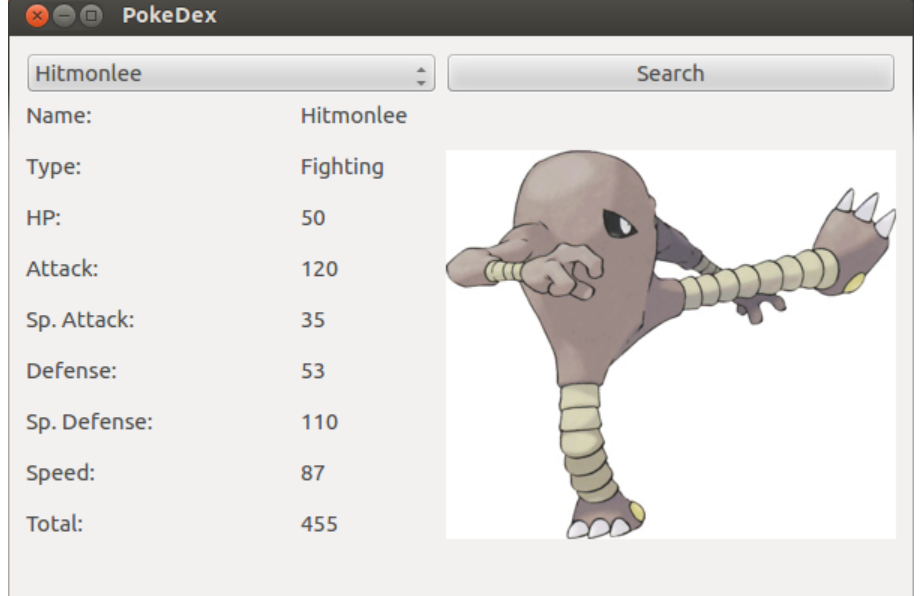

In [ ]:
IF THE ABOVE CODE WORKS IT WILL GIVE OUTPUT LIKE THIS